In [1]:
# partial imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import plotly.express as pl
import matplotlib.pyplot as plt


# Local imports
import common_paths
import wetter_api as wt
import model_eval as me

# Model Traning

In [2]:
state = "Brandenburg"
parameter_list = [
    wt.DwdObservationParameter.MONTHLY.PRECIPITATION_HEIGHT,
    wt.DwdObservationParameter.MONTHLY.CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT,
    wt.DwdObservationParameter.MONTHLY.TEMPERATURE_AIR_MAX_200,
]

In [3]:
future_bb_weather = pd.read_csv(
    common_paths.DATA.joinpath("dwd/future_Brandenburg.csv")
)
future_bb_weather.drop(columns=["Unnamed: 0", "Bundesland"], inplace=True)
# adjust precipitation to same unit
future_bb_weather["pr"] = future_bb_weather["pr"] * 3600 * 24 * 30
future_bb_weather

,pr,tasmax,sfcWind,Year,Month
0,51.580644,278.43063,4.900000,2024,1
1,54.774196,278.38547,4.761291,2024,1
2,63.967742,278.19840,4.422581,2024,1
3,47.709679,278.55966,4.416129,2024,1
4,47.709679,278.54030,4.367742,2024,1
...,...,...,...,...,...
70390,41.612901,274.10160,4.516129,2054,1
70391,51.967742,273.57257,5.196774,2054,1
70392,51.967742,273.62740,5.316129,2054,1
70393,45.483872,273.60483,5.216129,2054,1


In [4]:
data = me.prepare_data(parameter_list, state)
data

,Year,Month,station_id,pr,sfcWind,tasmax,nFires,area
259,1996,1,00164,0.2,3.384206,275.15,1.0,0.0
260,1996,1,00427,0.7,3.729582,277.45,1.0,0.0
261,1996,1,00650,1.0,2.276450,277.65,1.0,0.0
262,1996,1,00880,2.8,2.746595,280.65,1.0,0.0
263,1996,1,01001,1.4,3.770945,281.15,1.0,0.0
...,...,...,...,...,...,...,...,...
8370,2022,12,03158,37.2,2.897073,290.65,0.0,0.0
8371,2022,12,03376,40.7,2.897073,290.65,0.0,0.0
8373,2022,12,03987,58.8,4.409306,290.45,0.0,0.0
8377,2022,12,05825,45.4,2.897073,289.95,0.0,0.0


In [5]:
test = me.station_means(data)
test_area = test.astype("float").groupby("Year")["area"].sum().reset_index()
test_nr = test.astype("float").groupby("Year")["nFires"].sum().reset_index()
sum = pd.merge(test_area, test_nr, on=["Year"], how="outer")

In [6]:
fig1 = pl.scatter(sum, x="Year", y="area", trendline="lowess")
fig2 = pl.scatter(sum, x="Year", y="nFires", trendline="lowess")
fig1.show()
fig2.show()

Text(0, 0.5, 'number of fires')

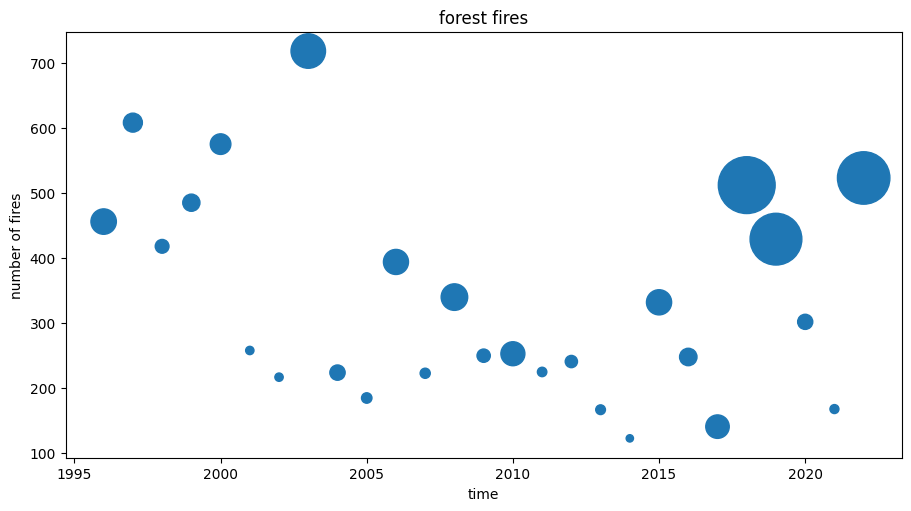

In [7]:
fig, ax = plt.subplots(figsize=(9, 5), layout="constrained")
ax.scatter("Year", "nFires", s="area", data=sum)

ax.set_title("forest fires")
ax.set_xlabel("time")
ax.set_ylabel("number of fires")

In [8]:
fig1 = pl.scatter(data, x="Month", y="area")
fig2 = pl.scatter(data, x="Month", y="nFires")
fig1.show()
fig2.show()

In [9]:
fig1 = pl.scatter(data, x="pr", y="nFires", title="nFires to Precipitation")
fig2 = pl.scatter(data, x="sfcWind", y="nFires", title="nFires to Wind")
fig3 = pl.scatter(data, x="tasmax", y="nFires", title="nFires to Temperature")

fig1.show()
fig2.show()
fig3.show()

In [10]:
fig1 = pl.scatter(data, x="pr", y="area", title="Area to Precipitation")
fig2 = pl.scatter(data, x="sfcWind", y="area", title="Area to Wind")
fig3 = pl.scatter(data, x="tasmax", y="area", title="Area to Temperature")

fig1.show()
fig2.show()
fig3.show()

In [11]:
fig1 = pl.scatter(data, x="nFires", y="area", trendline="ols", title="numbers to area")
fig1.show()

<Axes: >

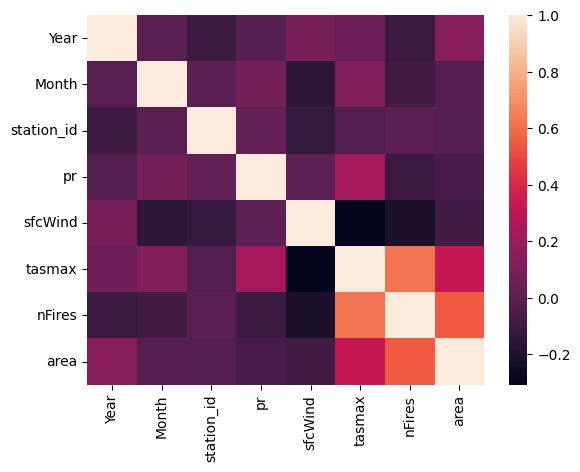

In [12]:
sb.heatmap(data.corr(method="pearson", numeric_only=False))

In [13]:
str_parameter_list = [str(param) for param in parameter_list]
dates = data[["Year", "Month"]]
feature_list = ["sfcWind", "pr", "tasmax"]

X_nr = data[feature_list]
y_nr = data["nFires"]

# X, y, dates = shuffle(X, y, dates, random_state=42)
X_train_nr, X_test_nr, y_train_nr, y_test_nr, dates_train, dates_test = (
    train_test_split(X_nr, y_nr, dates, test_size=0.2, random_state=42)
)

In [14]:
X_scaled_train = RobustScaler().fit_transform(X_train_nr)
X_scaled_test = RobustScaler().fit_transform(X_test_nr)

In [15]:

quantile_transformer = QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_scaled_train)
X_test_trans = quantile_transformer.transform(X_scaled_test)

In [16]:

param_grid = {
    "n_estimators": [70, 80, 100],
    "max_depth": [3, 5, 6],  # Smaller range for max depth
    "min_samples_leaf": [2, 3, 5],
    "min_samples_split": [5, 7, 8],
}
gbr = GradientBoostingRegressor()
cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(
    estimator=gbr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error"
)
# searching for the right parameters using random Forest on a 5-fold Cross Validation (cv) and the nmse
nr_grid = grid_search.fit(X_scaled_train, y_train_nr)

# saving best parameters and model
nr_best_params = grid_search.best_params_
nr_best_model = grid_search.best_estimator_
print(nr_best_params)
print(nr_best_model)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80}
GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=8,
                          n_estimators=80)


In [17]:
# predict 'Anzahl Waldbrände' with the model
y_pred_nr = nr_best_model.predict(X_scaled_test)


mse = mean_squared_error(y_test_nr, y_pred_nr)
r2 = r2_score(y_test_nr, y_pred_nr)
mae = mean_absolute_error(y_test_nr, y_pred_nr)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 838.9786846073146
R2 Score: 0.5688309562080816
MAE: 16.3490241574849
